### **Imports**

In [1350]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [1351]:
import torch
import torch.nn as nn

In [1352]:
import importlib
import utils, models, training_utils
importlib.reload(utils)
importlib.reload(models)
importlib.reload(training_utils)

<module 'training_utils' from '/Users/pawelgrzeszczyk/Documents/02_studies/master/portfolio-optimization-dl/main/modeling/training_utils.py'>

### **Device**

In [1353]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # fallback to CPU if MPS isn't available

print(f"Using device: {device}")

Using device: mps


### **Reading the dataset**

In [1354]:
# Reading data, renaming columns and reordering
data = pd.read_csv('../data/data_files/w20_stock.csv').filter(regex='^Close_')
data.columns = [x.split('_')[1].split('.')[0] for x in data.columns]
data['Date'] = pd.read_csv('../data/data_files/w20_stock.csv')['Date']
data.insert(0, 'Date', data.pop('Date'))

# Date as index
data = data.set_index('Date')

# Getting the first row with no NaN values
first_full_row = data.dropna().first_valid_index()
print(f'First row with no NaN values is from: ({first_full_row})')

# Removing rows with NaN values
data = data.loc[first_full_row:]
print(f'Number of rows with NaN values removed: {first_full_row}')
print(f'Number of rows with no NaN values: {data.shape[0]}')

# Take only sample of assets
data = data[data.columns[:4]]
data.head()

First row with no NaN values is from: (2021-05-27)
Number of rows with NaN values removed: 2021-05-27
Number of rows with no NaN values: 792


,ALE,ALR,BDX,CDR
Date,,,,
2021-05-27,58.279999,32.900002,313.5,175.500000
2021-05-28,58.500000,33.990002,306.0,178.580002
2021-05-31,57.660000,33.740002,298.5,168.740005
2021-06-01,59.209999,34.480000,299.0,153.380005
2021-06-02,59.180000,34.410000,295.0,161.580002


In [1355]:
# data, X_SEQ_LEN = utils.generate_data(end_date=datetime(2023, 1, 30),
#                                    days=100,
#                                    num_ascending_start=2,
#                                    num_descending_start=2,
#                                    swap_count=10)
# # How many "next" days should be used to set the true label
# Y_SEQ_LEN = 1

# data

### **Prepare data for the model**

**Calculating percentage changes**

In [1356]:
# Calculate daily returns
data_returns = data.pct_change().dropna()

# Add new row equal to 0 - don't invest in anything
data_returns['SAVE'] = 0

print(f'Data shape: {data_returns.shape}')
data_returns.head()

Data shape: (791, 5)


,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-05-28,0.003775,0.033131,-0.023923,0.017550,0
2021-05-31,-0.014359,-0.007355,-0.024510,-0.055101,0
2021-06-01,0.026882,0.021932,0.001675,-0.091028,0
2021-06-02,-0.000507,-0.002030,-0.013378,0.053462,0
2021-06-04,-0.006928,0.009881,0.011864,0.059537,0


**Convert to target shape**

In [1357]:
X_SEQ_LEN = 30
Y_SEQ_LEN = 5

In [1358]:
import numpy as np
import torch

X_train, X_test, Y_train, Y_test = utils.create_sequences(data_returns = data_returns, 
                                                          X_seq_len = X_SEQ_LEN, 
                                                          Y_seq_len = Y_SEQ_LEN, 
                                                          test_size=0.2,
                                                          device=device)

In [1359]:
print(f'X shape: \n\t{X_train.shape}')
print(f'X sample: \n\t{X_train[0]}')

X shape: 
	torch.Size([605, 30, 5])
X sample: 
	tensor([[ 0.0038,  0.0331, -0.0239,  0.0175,  0.0000],
        [-0.0144, -0.0074, -0.0245, -0.0551,  0.0000],
        [ 0.0269,  0.0219,  0.0017, -0.0910,  0.0000],
        [-0.0005, -0.0020, -0.0134,  0.0535,  0.0000],
        [-0.0069,  0.0099,  0.0119,  0.0595,  0.0000],
        [ 0.0048,  0.0037, -0.0369, -0.0084,  0.0000],
        [ 0.0034, -0.0224,  0.0122,  0.0073,  0.0000],
        [ 0.0066, -0.0114,  0.0052,  0.0322,  0.0000],
        [-0.0208,  0.0110, -0.0188, -0.0142,  0.0000],
        [-0.0017, -0.0167, -0.0052,  0.0678,  0.0000],
        [ 0.0034,  0.0057,  0.0105,  0.0053,  0.0000],
        [ 0.0050, -0.0306,  0.0000,  0.0653,  0.0000],
        [ 0.0172,  0.0456, -0.0052, -0.0645,  0.0000],
        [-0.0119,  0.0246, -0.0052, -0.0276,  0.0000],
        [ 0.0162, -0.0226, -0.0123,  0.0158,  0.0000],
        [-0.0108, -0.0091,  0.0000, -0.0026,  0.0000],
        [-0.0194,  0.0209,  0.0106, -0.0305,  0.0000],
        [ 0.0343,

In [1360]:
print(f'Y shape: \n\t{Y_train.shape}')
print(f'Y sample: \n\t{Y_train[0]}')

Y shape: 
	torch.Size([605, 5, 5])
Y sample: 
	tensor([[ 0.0299, -0.0476, -0.0037,  0.0737,  0.0000],
        [-0.0137,  0.0280,  0.0074,  0.0079,  0.0000],
        [ 0.0111,  0.0566,  0.0055, -0.0369,  0.0000],
        [-0.0068, -0.0159, -0.0037, -0.0052,  0.0000],
        [ 0.0084, -0.0032,  0.0037, -0.0040,  0.0000]], device='mps:0')


**True labels**

| Function                  | Arguments      | Description                                                                  |
|---------------------------|----------------|------------------------------------------------------------------------------|
| `get_Y_max_one`            | `Y`            | Pick one asset with the highest returns                                       |
| `get_Y_max_light`          | `Y`            | Distribute weights among assets with positive returns depending on the returns value |
| `get_Y_sharpe_one`         | `X, Y`         | Pick one asset with the highest Sharpe ratio                                  |
| `get_Y_sharpe_light`       | `X, Y`         | Distribute weights among assets with positive returns depending on the Sharpe ratio value |

In [1361]:
Y_train_true_labels = utils.get_Y_sharpe_light(X_train, Y_train).to(device)
Y_test_true_labels = utils.get_Y_sharpe_light(X_test, Y_test).to(device)

print(f'Y_true_labels shape: \n\t{Y_true_labels.shape}')
print(f'Y_true_labels sample: \n\t{Y_true_labels[0]}')

Y_true_labels shape: 
	torch.Size([72, 5])
Y_true_labels sample: 
	tensor([0.8247, 0.1753, 0.0000, 0.0000, 0.0000])


### **Model**

In [1362]:
input_size = X_train.shape[2]
hidden_size = 256
output_size = Y_true_labels.shape[1]

# Create the model
model = models.LSTMModel(input_size=input_size,
                  hidden_size=hidden_size,
                  output_size=output_size,
                  num_layers=2,
                  device=device).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### **Training**

In [1363]:
model_results = training_utils.train(
                    model=model,
                    X_train=X_train,
                    Y_train=Y_train,
                    Y_train_true_labels=Y_train_true_labels,
                    X_test=X_test,
                    Y_test=Y_test,
                    Y_test_true_labels=Y_test_true_labels,
                    optimizer=optimizer,
                    criterion=criterion,
                    profit_calc_fn=utils.calculate_portfolio_return,
                    epochs=1000,
                    print_every=100)

Epoch: 100 | train_loss: 0.0964 | train_profit: 0.29% | test_loss: 0.0817 | test_profit: 0.29%
Epoch: 200 | train_loss: 0.0957 | train_profit: 0.39% | test_loss: 0.0817 | test_profit: 0.29%
Epoch: 300 | train_loss: 0.0952 | train_profit: 0.35% | test_loss: 0.0816 | test_profit: 0.29%
Epoch: 400 | train_loss: 0.0939 | train_profit: 0.40% | test_loss: 0.0811 | test_profit: 0.29%
Epoch: 500 | train_loss: 0.0941 | train_profit: 0.43% | test_loss: 0.0822 | test_profit: 0.28%
Epoch: 600 | train_loss: 0.0891 | train_profit: 0.77% | test_loss: 0.0814 | test_profit: 0.30%
Epoch: 700 | train_loss: 0.0848 | train_profit: 1.52% | test_loss: 0.0828 | test_profit: 0.31%
Epoch: 800 | train_loss: 0.0766 | train_profit: 2.63% | test_loss: 0.0860 | test_profit: 0.31%
Epoch: 900 | train_loss: 0.0708 | train_profit: 2.99% | test_loss: 0.0796 | test_profit: 0.36%
Epoch: 1000 | train_loss: 0.0696 | train_profit: 4.35% | test_loss: 0.0803 | test_profit: 0.36%


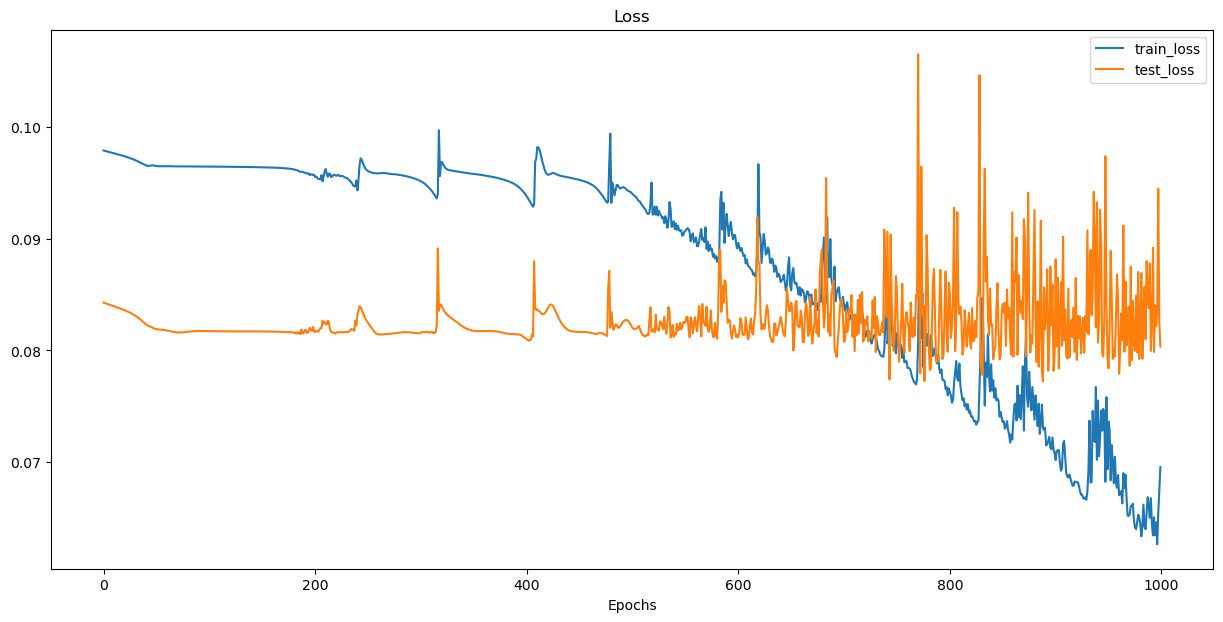

In [1364]:
utils.plot_loss_curves(model_results)

## **Evaluation**

In [1365]:
with torch.no_grad():
    training_output_weights = model(X_train)

with torch.no_grad():
    testing_output_weights = model(X_test)

In [1366]:
all_output_weights = torch.cat((training_output_weights, testing_output_weights))
all_output_weights.shape

torch.Size([757, 5])

In [1367]:
all_output_weights_df = pd.DataFrame(all_output_weights.cpu().numpy(), columns=data_returns.columns)
all_output_weights_df['Date'] = data_returns.index[X_SEQ_LEN: None if Y_SEQ_LEN == 1 else -(Y_SEQ_LEN - 1)]
all_output_weights_df['Date'] = pd.to_datetime(all_output_weights_df['Date'])
all_output_weights_df = all_output_weights_df.set_index('Date')
all_output_weights_df

,ALE,ALR,BDX,CDR,SAVE
Date,,,,,
2021-07-12,0.122625,0.665412,0.067124,0.090290,0.054549
2021-07-13,0.071272,0.639055,0.180708,0.065563,0.043403
2021-07-14,0.166136,0.326881,0.184045,0.281499,0.041439
2021-07-15,0.023657,0.739738,0.174024,0.024695,0.037887
2021-07-16,0.166786,0.374067,0.253310,0.111291,0.094546
...,...,...,...,...,...
2024-07-09,0.218051,0.351401,0.126802,0.212419,0.091328
2024-07-10,0.224616,0.334244,0.129987,0.215391,0.095762
2024-07-11,0.233264,0.308687,0.135358,0.224017,0.098675


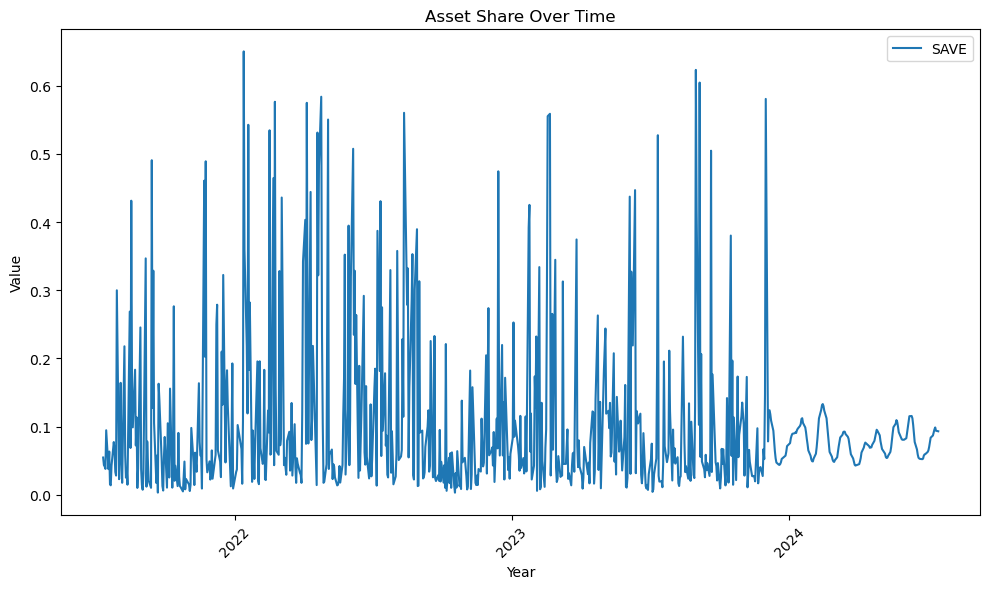

In [1372]:
utils.plot_asset_share(all_output_weights_df[['SAVE']])
# utils.plot_asset_share(all_output_weights_df)

### **Profit calculation**

In [1369]:
max_daily_returns, max_total_returns = utils.calculate_max_return(Y_test)

print(f'Total max returns: {max_total_returns}')
# print(f'Daily max returns: {max_daily_returns}')

Total max returns: 21.9173641204834


In [1370]:
portfolio_daily_returns, portfolio_total_returns = utils.calculate_portfolio_return(testing_output_weights, Y_test)

print(f'Total portfolio returns: {portfolio_total_returns}')
# print(f'Daily portfolio returns: {portfolio_daily_returns}')

Total portfolio returns: 0.3614543676376343


In [1371]:
print(f'Earned profit vs max profit: {portfolio_total_returns:.2f}% vs {max_total_returns:.2f}%')

Earned profit vs max profit: 0.36% vs 21.92%
